# Projet P6 : Classifiez automatiquement des biens de consommation

## Contexte

<b> MISSION 1 : </b>

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.

Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 
- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters
 
Pourrais-tu nous démontrer ainsi la faisabilité de regrouper automatiquement des produits de même catégorie ? 

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.
 
Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : 
- deux approches de type bag-of-words, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

<b> MISSION 2 : </b>

Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle. 

De plus, nous souhaitons élargir notre gamme de produits à l’épicerie fin

 

Pour cela, pourrais-tu tester la collecte de produits à base de “champagne” via l’API dis ponib
https://developer.edamam.com/food-database-apiei ? 

 

Pourrais-tu ensuite nous proposer un script ou notebook Python permettant une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

## Etapes du projet :

Démontrer la faisabilité de regrouper automatiquement des produits de même catégorie.

- <b> Etape préliminaire : </b> Importation des données ( --> NoteBook1 : Traitement des textes )
- <b> Etape 1 : </b> Text cleaning et feature engineering ( --> NoteBook1 : Traitement des textes ) 
- <b> Etape 2 : </b> Catégorisation des descriptions ( --> NoteBook 2 et 3 : Méthodes bag of words et Word_embedding )
- <b> Etape 3 : </b> Pré-traitement et classification d'images (SIFT et CNN) ( --> NoteBook4 : Traitement des images )
- <b> Etape 4 : </b> Classification supervisée des images ( --> NoteBook5 : Classification des images )
- <b> Etape 5 : </b> Collecte de produits via API ( --> NoteBook6 : Collecte produits API )

Livrables : 
- Un ou des notebooks (ou des fichiers .py) contenant les fonctions permettant le prétraitement et la feature extraction des données textes et images ainsi que les résultats de l’étude de faisabilité (graphiques, mesure de similarité)
- Un notebook de classification supervisée des images
- Un script Python (notebook ou fichier .py) de test de l’API et le fichier au format “csv” contenant les produits extraits

### Environnement de travail et librairies

In [2]:
import sys
# Mon environnement virtuel :
print(sys.executable)
# La version de Python dans mon environnement virtuel :
print(sys.version)

C:\Users\druar\anaconda3\envs\Formation_P6_IMAGES\python.exe
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


In [4]:
# Builtin
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'

# os.environ["OMP_NUM_THREADS"] = "5"
# Importer les autres bibliothèques après avoir défini les variables d'environnement

from os import listdir
import time

# Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Reduction de dimensions
from sklearn import decomposition
from sklearn import manifold

# Encodage
from sklearn import preprocessing

# Viz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.image import imread
import seaborn as sns

# CNN
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

sns.set_palette('Set3')

# Clustering
from sklearn import cluster, metrics


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Utilisation de GPUs
  - Possibilité de passer par Google Colab pour utiliser les GPUs et gagner en temps de traitement.
  - Google Colaboratory : 
Colab is a hosted Jupyter Notebook service that requires no setup to use and provides free access to computing resources, including GPUs and TPUs. Colab is especially well suited to machine learning, data science, and education.
  - A noter : il n'est pas nécessaire de créer un compte pour utiliser Google Colab, possibilité de l'utiliser sans authentification, mais dans ce cas, on ne peut pas enregistrer les modifications directement sur notre Google Drive. Il faut dans ce cas télécharger le travail sous forme de fichier ou l'enregistrer sur un autre service de stockage en ligne..

## Etape 4 : Classification supervisée des images

ETAPE 4

    1. Préparation du DataSet (+ Test / Train / Validation split)
    
    2. Approche simple avec préparation des images (avant classification)
        - Création du modèle de classification
        - Préparation des images
        - Résultats
   
    3. Approche récente proposée par Tensorflow.org par DataSet (avec data augmentation intégrée au modèle)
       - Création du modèle avec Data Augmentation
        - Préparation des images
        - Résultats

### 1. Préparation du DataSet

#### -- Chemin des images --

In [13]:
path = "C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\Flipkart\\Images\\"

#### -- Importation des articles --

In [16]:
articles_images = pd.read_csv("C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P6\\data\\Flipkart\\flipkart_com-ecommerce_sample_1050.csv")

In [18]:
# Selection des variables qui vont nous intéresser
vars = ['product_category_tree','image']
articles_images = articles_images[vars]
articles_images.head()

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


#### -- Ajouter une colonne avec le lien complet de chaque image --

In [21]:
articles_images["image_path"] = path+articles_images['image']

#### -- Splitter la variable 'product_category_tree' en sous-catégories --

In [24]:
# Retier les signes [""] dans le texte de la variable
articles_images['product_category_tree'] = articles_images['product_category_tree'].str.slice(2, -2)
# Séparer les catégories en plusieurs colonnes
categories_split = articles_images['product_category_tree'].str.split(' >> ', expand=True)

# Renommer les colonnes pour une meilleure clarté
categories_split.columns = ['category_product', 'category_2', 'category_3','category_4', 'category_5', 'category_6','category_7']

# Joindre la colonne category_product avec le DataFrame original
articles_images = articles_images.join(categories_split['category_product'])
articles_images = articles_images.drop(columns='product_category_tree') # On supprime la variable d'origine
articles_images.head()

,image,image_path,category_product
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Home Furnishing


#### -- Encodage de la catégorie de produit --

In [27]:
# Encodage de la catégorie de produit
le = preprocessing.LabelEncoder()
articles_images["category_code"] = le.fit_transform(articles_images["category_product"])
print(articles_images["category_code"])

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: category_code, Length: 1050, dtype: int32


<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- nous avons 1050 images de produits uniques dans l'échantillon de données avec leur catégorie
- il y a 7 catégories de produits
    
</div>

#### -- Exemples d'images par label --

Home Furnishing


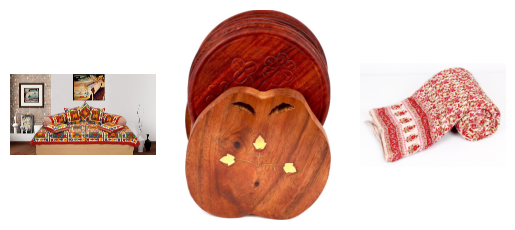

Baby Care


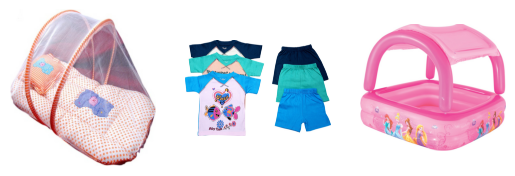

Watches


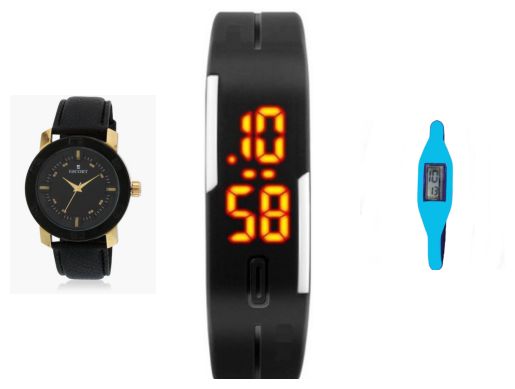

Home Decor & Festive Needs


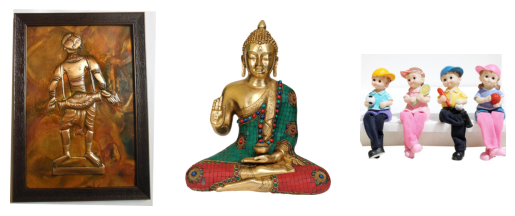

Kitchen & Dining


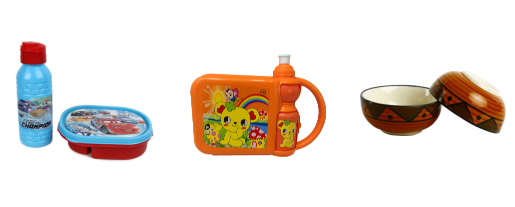

Beauty and Personal Care


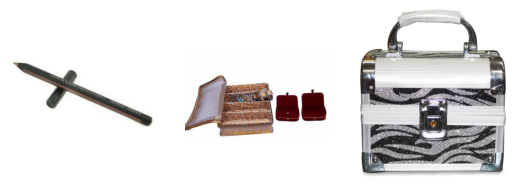

Computers


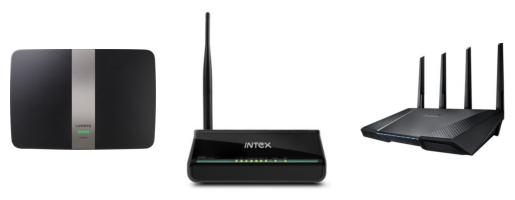

In [31]:
# Liste des labels uniques
list_labels = articles_images["category_product"].unique()

# Fonction pour obtenir les noms d'image pour une catégorie donnée
def list_fct(name):
    list_image_name = articles_images.loc[articles_images["category_product"] == name, "image"].tolist()
    return list_image_name

# Boucle pour chaque catégorie de produit
for name in list_labels:
    print(name)
    list_images = list_fct(name)

    # Affichage des images
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_images[i + 10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()

#### -- Extraction d'un échantillon de TEST --

In [34]:
# articles_images_test = articles_images.groupby('category_product', group_keys=False).apply(lambda x: x.sample(frac=0.15, random_state=42))
articles_images_train_val, articles_images_test = train_test_split(articles_images, test_size=0.15, random_state=42, stratify=articles_images['category_product'])
print(articles_images_test.shape, articles_images_train_val.shape)

(158, 4) (892, 4)


In [36]:
articles_images_test['category_product'].value_counts()

category_product
Home Furnishing               23
Home Decor & Festive Needs    23
Computers                     23
Watches                       23
Kitchen & Dining              22
Beauty and Personal Care      22
Baby Care                     22
Name: count, dtype: int64

### 2. Approche simple avec préparation des images

#### -- Création du modèle de classification --

In [40]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

#### -- Fonction de préparation des images --

In [43]:
def image_prep_fct(data):
    prepared_images = []
    for _, row in data.iterrows():
        img = load_img(row['image_path'], target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(articles_images_train_val)
print(images_np.shape)
images_np_test = image_prep_fct(articles_images_test)
print(images_np_test.shape)

C:\Users\druar\anaconda3\envs\Formation_P6_IMAGES\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(892, 224, 224, 3)
(158, 224, 224, 3)


#### -- Echantillon TEST --

In [45]:
X = images_np
y = to_categorical(articles_images_train_val['category_code'], num_classes=7)

X_test = images_np_test
y_test = to_categorical(articles_images_test['category_code'], num_classes=7)

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

#### -- Echantillon TRAIN-VALIDATION --

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
X_train.shape
X_val.shape

(179, 224, 224, 3)

In [48]:
# Création du modèle
with tf.device('/gpu:0'): # Cela indique à TensorFlow d'exécuter toutes les opérations liées à la création du modèle sur le GPU si disponible
    model1 = create_model_fct() 

# Création du callback
model1_save_path1 = "./model1_best_weights.keras" # Définition du chemin où les poids du modèle seront sauvegardés lors de l'utilisation du callback ModelCheckpoint.
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min') # Création d'un callback ModelCheckpoint qui surveille la perte de validation (val_loss). Il sauvegarde uniquement les poids du modèle qui obtiennent la meilleure valeur de perte de validation (mode='min') dans le fichier spécifié par model1_save_path1. L'option verbose=1 affiche des messages pendant l'entraînement.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5) # Création d'un callback EarlyStopping qui arrête l'entraînement si la perte de validation (val_loss) cesse de s'améliorer (mode='min') pendant un certain nombre d'époques (patience=5). 
callbacks_list = [checkpoint, es] # Liste contenant tous les callbacks créés (ModelCheckpoint et EarlyStopping). Cette liste est passée comme argument lors de l'entraînement du modèle pour appliquer ces callbacks à chaque époque.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [53]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=20, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3619 - loss: 8.1684
Epoch 1: val_loss improved from inf to 1.45718, saving model to ./model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.3709 - loss: 7.9876 - val_accuracy: 0.6480 - val_loss: 1.4572
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6554 - loss: 2.2197
Epoch 2: val_loss improved from 1.45718 to 1.38748, saving model to ./model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.6573 - loss: 2.2081 - val_accuracy: 0.7095 - val_loss: 1.3875
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7441 - loss: 1.6013
Epoch 3: val_loss improved from 1.38748 to 0.97370, saving model to ./model1_best_weights.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7441 - loss: 1.5968 - val_accuracy: 0.7318 - val_loss: 0.9737
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8173 - loss: 0.8915
Epoch 4: val_loss improved from 0.97370

In [55]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 1.0000 - loss: 0.0080
Training Accuracy: 1.0000

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7798 - loss: 0.8833
Validation Accuracy:  0.7933


In [56]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8212
Test Accuracy       :  0.7848


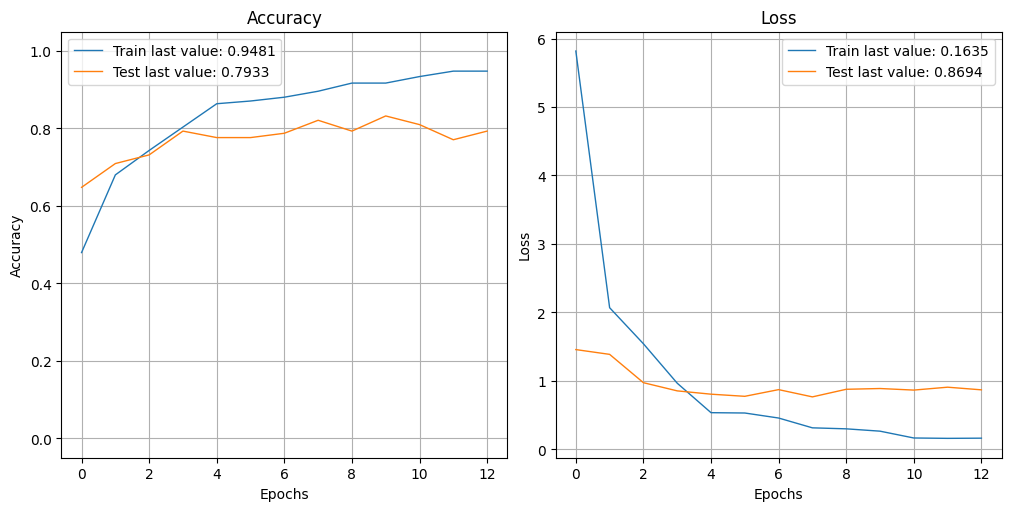

In [57]:
from plot_keras_history import show_history, plot_history

show_history(history1)
plot_history(history1, path="standard.png") # Ici train = train et test = validation
plt.close()

#### -- Résultats sur l'échantillon de TEST --

In [74]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model1.predict(X_test), axis=1)
predictions = model1.predict(X_test)
print(y_test_num)
print()
print(y_test_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
[4 4 5 5 3 3 1 3 3 2 6 1 5 0 2 5 6 6 4 4 1 0 0 0 0 1 2 1 4 5 3 5 4 0 1 2 5
 6 4 3 0 0 2 6 6 4 0 2 1 2 2 0 0 3 5 6 3 1 3 2 6 6 0 6 0 4 5 3 2 3 3 5 0 1
 3 4 2 2 1 2 0 6 3 5 6 4 6 2 2 6 3 1 5 1 4 6 6 4 1 6 5 2 3 4 1 3 2 5 4 0 5
 2 4 1 3 2 5 4 3 1 5 6 1 1 6 1 3 0 3 5 4 4 2 1 5 2 4 5 1 6 2 2 6 0 0 5 0 4
 4 3 6 4 3 0 5 0 6 1]

[1 0 5 5 3 0 1 2 3 3 6 1 0 0 2 5 6 6 4 4 1 3 0 0 0 1 2 1 4 5 3 5 0 4 1 5 5
 2 4 3 0 4 2 6 6 4 0 2 1 2 5 4 0 3 5 6 2 3 3 2 6 6 4 0 0 4 5 3 2 3 3 5 4 1
 3 4 2 2 1 2 0 3 3 5 6 4 3 2 2 6 3 1 5 3 4 6 6 0 1 3 5 2 3 4 1 3 2 3 4 0 5
 5 4 1 3 2 5 4 3 1 5 2 6 1 6 1 5 0 3 5 4 4 2 3 5 2 4 5 5 6 4 6 6 0 4 5 0 4
 4 3 6 4 3 0 5 0 6 1]


In [75]:
# Afficher quelques prédictions
for i in range(10):
    print(f"Image {i}: Vérité terrain = {y_test_num[i]}, Prédiction = {y_test_pred[i]}, Probabilités = {predictions[i]}")

Image 0: Vérité terrain = 4, Prédiction = 1, Probabilités = [3.6832789e-04 9.7406840e-01 2.4686174e-02 8.5316715e-04 1.9998626e-05
 4.6411003e-07 3.5484429e-06]
Image 1: Vérité terrain = 4, Prédiction = 0, Probabilités = [7.8945851e-01 9.7478136e-02 3.9827120e-03 4.4468638e-02 5.0802484e-02
 1.3678134e-02 1.3129758e-04]
Image 2: Vérité terrain = 5, Prédiction = 5, Probabilités = [1.2596713e-01 1.3078232e-05 8.3591587e-09 5.6840933e-04 4.0473827e-07
 8.7344974e-01 1.2174412e-06]
Image 3: Vérité terrain = 5, Prédiction = 5, Probabilités = [2.7810002e-04 5.7610318e-06 1.6236054e-08 3.2614506e-07 9.4073293e-08
 9.9971575e-01 6.8254014e-10]
Image 4: Vérité terrain = 3, Prédiction = 3, Probabilités = [2.9232547e-07 1.9365163e-09 2.0171337e-05 9.9996066e-01 3.3153399e-10
 1.8880039e-05 7.1533257e-12]
Image 5: Vérité terrain = 3, Prédiction = 0, Probabilités = [9.4939506e-01 1.0609174e-03 2.2595334e-03 4.3400802e-02 1.6558695e-05
 2.4890027e-03 1.3782424e-03]
Image 6: Vérité terrain = 1, Prédi

In [76]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)

[[15  0  0  1  6  0  0]
 [ 0 17  0  3  0  1  1]
 [ 0  0 17  1  1  3  1]
 [ 1  0  2 19  0  1  0]
 [ 3  1  0  0 19  0  0]
 [ 1  0  0  1  0 20  0]
 [ 1  0  2  3  0  0 17]]


In [77]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [78]:
y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[15  0  0  1  6  0  0]
 [ 0 17  0  3  0  1  1]
 [ 0  0 17  1  1  3  1]
 [ 1  0  2 19  0  1  0]
 [ 3  1  0  0 19  0  0]
 [ 1  0  0  1  0 20  0]
 [ 1  0  2  3  0  0 17]]

              precision    recall  f1-score   support

           0       0.71      0.68      0.70        22
           1       0.94      0.77      0.85        22
           2       0.81      0.74      0.77        23
           3       0.68      0.83      0.75        23
           4       0.73      0.83      0.78        23
           5       0.80      0.91      0.85        22
           6       0.89      0.74      0.81        23

    accuracy                           0.78       158
   macro avg       0.80      0.78      0.79       158
weighted avg       0.80      0.78      0.79       158



In [79]:
label_corresp = ['Baby Care','Beauty and Personal Care', 'Computers','Home Decor & Festive Needs' , 'Home Furnishing',  'Kitchen & Dining', 'Watches']

<Axes: >

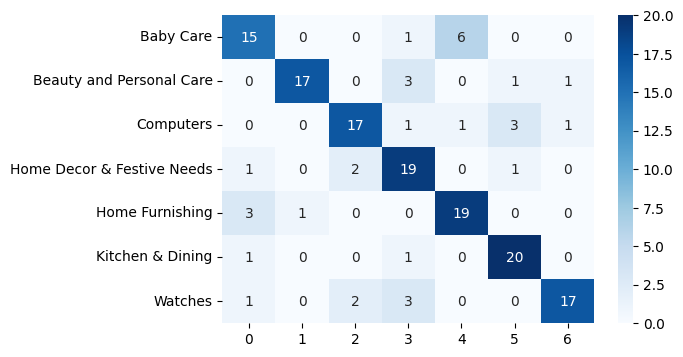

In [80]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in label_corresp],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

### 3. Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

#### -- Préparation des images --

In [90]:
def process_path(image_path, label, index):
    ''' Cette fonction charge une image à partir de son chemin, la décode, 
    la redimensionne et la normalise. Elle retourne l'image et son label. '''
    # Lire l'image à partir du chemin et la redimensionner
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    # img = tf.cast(img, tf.float32) / 127.5 - 1.0  # Normalisation
    return img, label, index

In [92]:
batch_size = 32

def dataset_fct(dataframe, validation_split=0, subset=None, batch_size=32):
    
    ''' Encodage des labels : Les labels de catégories sont convertis en indices entiers puis en vecteurs one-hot encodés.
        Création du dataset : Un tf.data.Dataset est créé à partir des chemins d'images et des labels.
        Mélange et fractionnement : Le dataset est mélangé, puis fractionné en ensembles d'entraînement et de validation selon le validation_split et le subset spécifié.
        Chargement des images : La fonction process_path est appliquée pour charger les images et leurs labels.
        Configuration du dataset : Le dataset est configuré pour être performant, avec des lots et du préchargement. '''
    
    # Convertir les labels en one-hot encodés
    class_names = sorted(dataframe['category_product'].unique())
    num_classes = len(class_names)
    class_indices = {name: index for index, name in enumerate(class_names)}
    dataframe['label'] = dataframe['category_product'].map(class_indices)
    
    # Convertir les chemins d'images, les labels et les indices en tensors
    image_paths = dataframe['image_path'].values
    labels = tf.keras.utils.to_categorical(dataframe['label'].values, num_classes=num_classes)
    indices = dataframe.index.values
    
    # Créer un dataset à partir des chemins d'images, des labels et des indices
    def create_dataset(image_paths, labels, indices):
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels, indices))
        dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Configurer l'ensemble de données pour les performances : Dataset.prefetch chevauche le prétraitement des données et l'exécution du modèle pendant la formation.
        return dataset
    
    # Fractionner le dataset en ensembles d'entraînement et de validation
    if validation_split > 0:
        validation_size = int(validation_split * len(image_paths))
        train_size = len(image_paths) - validation_size
        
        train_dataset = create_dataset(image_paths[:train_size], labels[:train_size], indices[:train_size])
        validation_dataset = create_dataset(image_paths[train_size:], labels[train_size:], indices[train_size:])
        
        if subset == 'training':
            return train_dataset
        elif subset == 'validation':
            return validation_dataset
        else:
            raise ValueError("subset must be either 'training' or 'validation'")
    else:
        return create_dataset(image_paths, labels, indices)

In [94]:
# Définition des datasets d'entraînement et de validation
train_dataset = dataset_fct(articles_images_train_val, validation_split=0.2, subset='training')
val_dataset = dataset_fct(articles_images_train_val, validation_split=0.2, subset='validation')
test_dataset = dataset_fct(articles_images_test, validation_split=0)

# Vérification des datasets, shape pour une image
for image, label, indice in test_dataset.take(1):
    print(image.shape, label.shape, indice.shape)

(32, 224, 224, 3) (32, 7) (32,)


#### -- Augmentation des données : test sur une image --
L'augmentation des données consiste à appliquer des modifications sur les images existantes pour permettre au modèle d'apprendre sur une plus grande quantité et variété d'images.

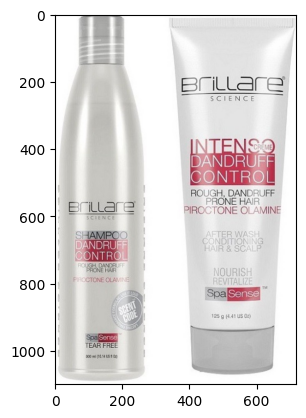

In [97]:
image = imread(articles_images['image_path'][59])
plt.imshow(image)

In [99]:
image = tf.expand_dims(image, 0)

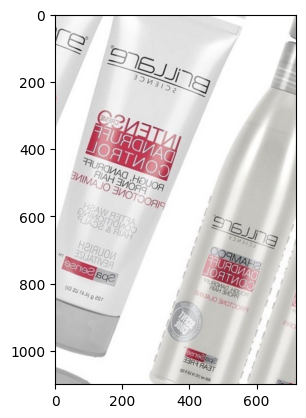

In [101]:
data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])

augmented_image = data_augmentation(image)
plt.imshow(augmented_image[0] / 255.0)

#### -- Définition du modèle --

In [104]:
# Définition du modèle
def create_model_fct2():
    # Définir l'entrée du modèle
    inputs = Input(shape=(224, 224, 3)) # La couche d'entrée est définie avec une forme explicite
    
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ])
    
    # Appliquer l'augmentation des données : la séquence de l'augmentation des données est appliquée aux entrées
    x = data_augmentation(inputs)
    x = Rescaling(1./127.5, offset=-1)(x)
    
    # Récupération du modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Appliquer le modèle de base
    x = model_base(x) # Le modèle pré-entraîné VGG16 est appliqué aux données après l'augmentation
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Régulation entre 0 et 1
    outputs = Dense(7, activation='softmax')(x)
    
    # Définir le modèle complet : Le modèle complet est défini en utilisant les entrées et les sorties
    model = Model(inputs=inputs, outputs=outputs)

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    # Affichage du résumé du modèle
    print(model.summary())
    
    return model


In [106]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()
    
# Création du callback
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


#### -- Entrainer le modèle --

In [109]:
# Créer des copies des datasets sans les indices
train_dataset_without_indices = train_dataset.map(lambda image, label, index: (image, label))
validation_dataset_without_indices = val_dataset.map(lambda image, label, index: (image, label))
test_dataset_without_indices = test_dataset.map(lambda image, label, index: (image, label))

In [111]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(train_dataset_without_indices,
                           batch_size=batch_size, epochs=20, callbacks=callbacks_list,
                           validation_data=validation_dataset_without_indices, verbose=1)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2116 - loss: 2.0324
Epoch 1: val_loss improved from inf to 1.33008, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2141 - loss: 2.0253 - val_accuracy: 0.7079 - val_loss: 1.3301
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5294 - loss: 1.4339
Epoch 2: val_loss improved from 1.33008 to 0.99730, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5305 - loss: 1.4307 - val_accuracy: 0.7472 - val_loss: 0.9973
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5943 - loss: 1.2096
Epoch 3: val_loss improved from 0.99730 to 0.83888, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5954 - loss: 1.2074 - val_accuracy: 0.7697 - val_loss: 0.8389
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6727 - loss: 1.0494
Epoch 4: val_loss improved from 0.83888

In [114]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(train_dataset_without_indices, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(validation_dataset_without_indices, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8681 - loss: 0.4159
Training Accuracy   : 0.8768

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8295 - loss: 0.5058
Validation Accuracy :  0.8202


In [115]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(validation_dataset_without_indices, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(test_dataset_without_indices, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8202
Test Accuracy       :  0.8228


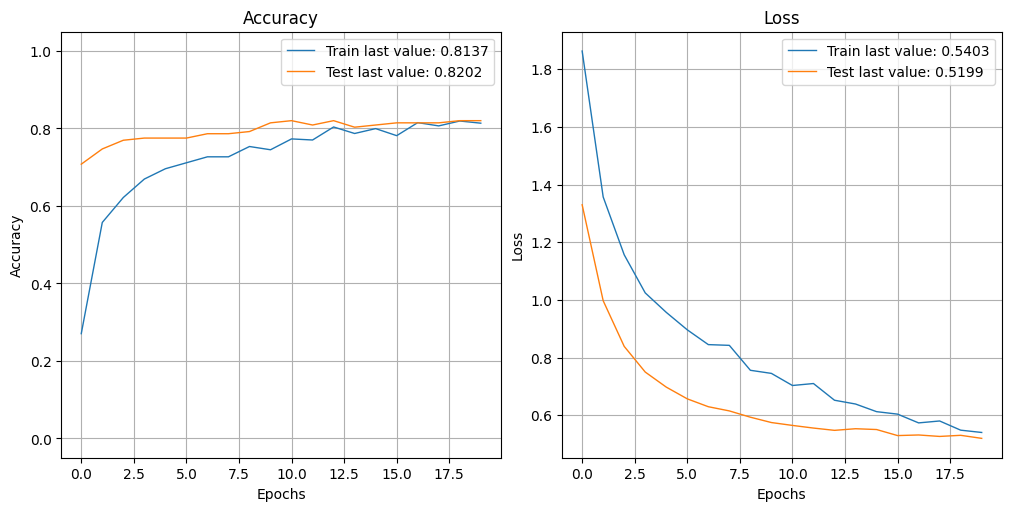

In [116]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4) # Test = validation sur les graphs
plot_history(history4, path="standard.png")
plt.close()

#### -- Résultats sur l'échantillon de TEST --

In [121]:
# Définition de l'échantillon test :
images_np_test = image_prep_fct(articles_images_test)

X_test = images_np_test
y_test = to_categorical(articles_images_test['category_code'], num_classes=7)

In [122]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model4.predict(X_test), axis=1)

print(y_test_num)
print()
print(y_test_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
[4 4 5 5 3 3 1 3 3 2 6 1 5 0 2 5 6 6 4 4 1 0 0 0 0 1 2 1 4 5 3 5 4 0 1 2 5
 6 4 3 0 0 2 6 6 4 0 2 1 2 2 0 0 3 5 6 3 1 3 2 6 6 0 6 0 4 5 3 2 3 3 5 0 1
 3 4 2 2 1 2 0 6 3 5 6 4 6 2 2 6 3 1 5 1 4 6 6 4 1 6 5 2 3 4 1 3 2 5 4 0 5
 2 4 1 3 2 5 4 3 1 5 6 1 1 6 1 3 0 3 5 4 4 2 1 5 2 4 5 1 6 2 2 6 0 0 5 0 4
 4 3 6 4 3 0 5 0 6 1]

[3 0 5 5 3 3 1 2 3 3 6 1 0 0 2 3 6 6 4 4 1 0 0 4 0 1 2 1 4 5 3 5 4 4 1 2 5
 6 4 2 5 0 2 6 6 4 0 2 1 2 3 0 0 3 5 6 2 3 3 2 6 6 0 6 0 4 5 3 1 3 3 5 4 1
 3 4 2 2 1 2 0 3 3 5 6 4 6 2 2 6 3 1 5 3 4 6 6 4 1 6 5 2 3 4 1 3 4 5 4 4 5
 2 4 1 3 2 5 1 3 1 3 6 6 1 6 1 1 0 3 5 4 4 2 2 5 2 4 5 2 6 2 6 6 0 4 5 0 4
 4 3 6 0 3 0 6 0 6 1]


In [124]:
predictions_Xtest = model4.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [125]:
# Afficher quelques prédictions
for i in range(10):
    print(f"Image {i}: Vérité terrain = {y_test_num[i]}, Prédiction = {y_test_pred[i]}, Probabilités = {predictions_Xtest[i]}")

Image 0: Vérité terrain = 4, Prédiction = 3, Probabilités = [0.03033995 0.18093969 0.3644161  0.37837285 0.0289794  0.00773187
 0.00922009]
Image 1: Vérité terrain = 4, Prédiction = 0, Probabilités = [0.3453832  0.14937781 0.01321391 0.23358835 0.20067619 0.05569099
 0.00206956]
Image 2: Vérité terrain = 5, Prédiction = 5, Probabilités = [0.0044304  0.02568604 0.00154112 0.03283314 0.00156903 0.58675694
 0.3471834 ]
Image 3: Vérité terrain = 5, Prédiction = 5, Probabilités = [0.03603817 0.03166891 0.0098692  0.19360586 0.00866291 0.7148815
 0.00527356]
Image 4: Vérité terrain = 3, Prédiction = 3, Probabilités = [0.0489828  0.00257246 0.00930065 0.92792284 0.00137777 0.00591551
 0.00392798]
Image 5: Vérité terrain = 3, Prédiction = 3, Probabilités = [0.10171508 0.03058702 0.10924651 0.70786035 0.01337558 0.03360331
 0.00361219]
Image 6: Vérité terrain = 1, Prédiction = 1, Probabilités = [5.0941813e-05 9.9916518e-01 1.5613429e-04 3.3228603e-04 4.7422811e-05
 2.4739245e-04 6.2023480e-07]


In [126]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)

[[16  0  0  0  5  1  0]
 [ 0 17  2  2  0  0  1]
 [ 0  1 18  2  1  0  1]
 [ 0  1  3 19  0  0  0]
 [ 2  1  0  1 19  0  0]
 [ 1  0  0  2  0 18  1]
 [ 0  0  0  1  0  0 22]]


In [127]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [128]:
y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[16  0  0  0  5  1  0]
 [ 0 17  2  2  0  0  1]
 [ 0  1 18  2  1  0  1]
 [ 0  1  3 19  0  0  0]
 [ 2  1  0  1 19  0  0]
 [ 1  0  0  2  0 18  1]
 [ 0  0  0  1  0  0 22]]

              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.85      0.77      0.81        22
           2       0.78      0.78      0.78        23
           3       0.70      0.83      0.76        23
           4       0.76      0.83      0.79        23
           5       0.95      0.82      0.88        22
           6       0.88      0.96      0.92        23

    accuracy                           0.82       158
   macro avg       0.82      0.82      0.82       158
weighted avg       0.82      0.82      0.82       158



In [129]:
label_corresp = ['Baby Care','Beauty and Personal Care', 'Computers','Home Decor & Festive Needs' , 'Home Furnishing',  'Kitchen & Dining', 'Watches']

<Axes: >

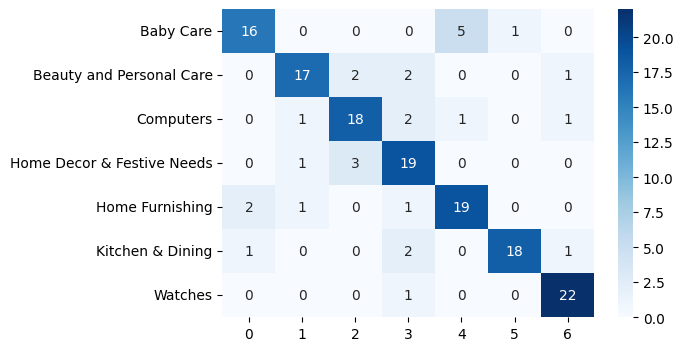

In [130]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in label_corresp],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [131]:
# Trouver les indices des images de la classe 2 qui sont mal classées
indices_mal_classes = np.where((y_test_num == 2) & (y_test_pred_transform != 2))[0]

# Récupérer les images correspondantes
images_mal_classes = images_np_test[indices_mal_classes]

print("Indices des images mal classées :", indices_mal_classes)

Indices des images mal classées : [  9  50  68 106 141]


In [132]:
# On récupère et on affiche les images concernées :
images_mal_classées = articles_images_test.iloc[indices_mal_classes]

In [133]:
images_mal_classées

,image,image_path,category_product,category_code,label
119,db6c79a1d852944a89e157793f392d67.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Computers,2,2
844,2c475daafe597ed93c1e27fcaa38d8cc.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Computers,2,2
87,e8ee7868b0c3d1d04b482cd4f3ec5ccc.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Computers,2,2
397,c2e71e7c97489d4efa5eab796ae354ac.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Computers,2,2
639,aeb421e416716d5f037d50e8c3b14cd7.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Computers,2,2


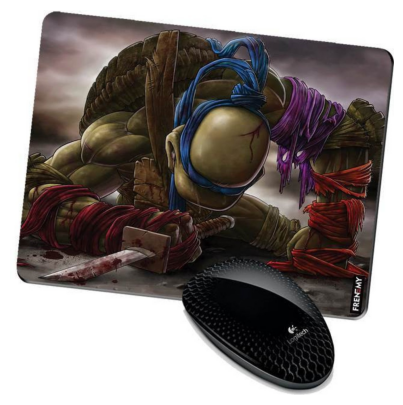

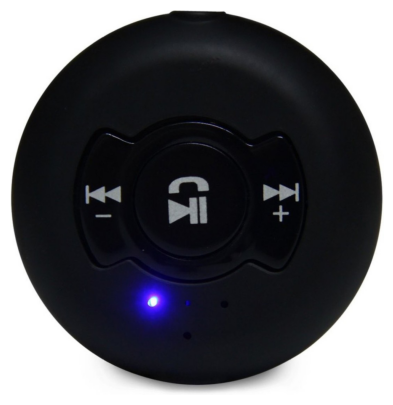

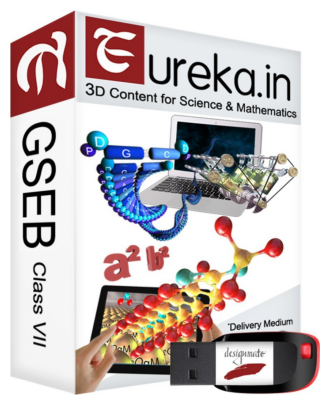

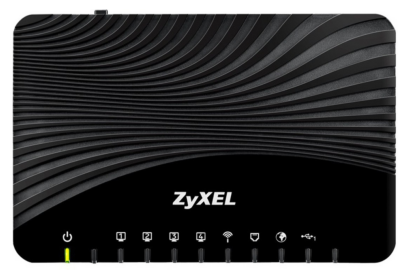

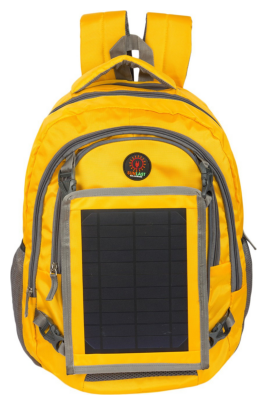

In [134]:
# Parcourir chaque ligne du DataFrame et afficher les images
for index, row in images_mal_classées.iterrows():
    image_path = row['image_path']
    image = imread(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Masquer les axes
    plt.show()

<div class="alert alert-block alert-info">
    <b> RESULTATS avec CNN et DataAugmentation : </b> 
    
- Avec une exactitude de 0.80, le modèle semble bien fonctionner globalement, bien qu'il y ait de la place pour l'amélioration, notamment pour certaines catégories spécifiques comme les ordinateurs.
- L'augmentation des données permet de diminuer le sur-apprentissage et ainsi de créer un modèle qui généralise beaucoup  mieux (écart entre le train et la validation largement réduit).
- La classe 6 (Watches) a la meilleure performance avec un score F1 de 0.91, ce qui indique que le modèle est très bon pour prédire cette catégorie, les images spécifiques des montres le permettent.
- Les images des catégories 0, 2, 3 et 4 (Baby care, computers, home and festive needs et home furnishing) sont les moins bien classées (- de 77% d'exactitude). La classe 2 a la plus faible précision (0.67) et un rappel de 0.78, ce qui indique qu'il y a des erreurs significatives dans la prédiction de cette catégorie (Computers), en regardant les images de plus prêt on se rend compte qu'elle peuvent préter à confusion (tapis de souris, boite de jeux avec un ordinateur dessiné dessus, image blanche, etc.).
    
</div>